In [29]:
SAVE = True

Utility plotting functions and node labels

In [19]:
import sys, os
sys.path.append('..')
from typing import Optional
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
from scipy import stats
from plotting.plot_circular_graph import plot_circular_graph
from plotting_styles import colors
import eval_reallabor_utils

import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import CONSTRUCTS_ANY_NON_CONDITIONAL as CONSTRUCTS
CONSTRUCTS = [c.lower() for c in CONSTRUCTS]
from feature_names import FLIP_OBSERVATION
POSITIVE_ITEMS = [i for i in range(len(LABELS)) if LABELS[i] not in FLIP_OBSERVATION]
NEGATIVE_ITEMS = [i for i in range(len(LABELS)) if LABELS[i] in FLIP_OBSERVATION]
PRINT_LABELS = [l.removeprefix('EMA_') for l in LABELS]
alph_order = np.argsort(LABELS)

def plot_network_graph(networks: tc.Tensor, directed: bool=True, invert_negative: bool=False, hide_self_connections: bool=True,
                       alpha_level: float=0.01, fisher_transform: bool=False, edge_threshold: Optional[float]=None, max_edge_number: Optional[int]=None,
                       node_labels: Optional[list]=None, title: Optional[str]=None, ax: Optional[plt.Axes]=None,
                       reveal_counterintuitive_connections: bool=True):    

    if fisher_transform:
        networks = tc.arctanh(networks)
    sig_adj = tc.tensor(stats.ttest_1samp(networks, 0, axis=0).pvalue)   # Show only connections with a weight significantly different from 0
    if fisher_transform:
        networks = tc.tanh(networks)
    networks = tc.nanmean(networks, dim=0)
    if fisher_transform:
        networks = tc.tanh(networks)
    if hide_self_connections:
        for i in range(networks.shape[0]):
            networks[i,i] = 0
    max_abs = networks.abs().max()
    if invert_negative:
        networks[NEGATIVE_ITEMS, :] *= -1
        networks[:, NEGATIVE_ITEMS] *= -1
        if node_labels is not None:
            node_labels = [node_labels[i] + '*' if i in NEGATIVE_ITEMS else node_labels[i] for i in range(len(node_labels)) ]
    if edge_threshold is not None:
        networks = networks * (networks.abs() > edge_threshold)
    networks = networks * (sig_adj < alpha_level)
    if max_edge_number is not None:
        flat_networks = networks.abs().flatten()
        threshold_value = tc.topk(flat_networks, k=max_edge_number).values[-1]
        networks = networks * (networks.abs() >= threshold_value)

    networks_pos = networks * (networks > 0)
    networks_neg = networks * (networks < 0)
    max_pos = networks_pos.abs().max()
    max_neg = networks_neg.abs().max()

    if reveal_counterintuitive_connections:
        if invert_negative:
            expected_sign = tc.ones_like(networks)
            expected_sign[tc.tensor(NEGATIVE_ITEMS)[:, None], tc.tensor(POSITIVE_ITEMS)[None, :]] *= -1
            expected_sign[tc.tensor(POSITIVE_ITEMS)[:, None], tc.tensor(NEGATIVE_ITEMS)[None, :]] *= -1
        else:
            expected_sign = tc.ones_like(networks)
        counterintuitive_connections = ((networks * expected_sign) < 0).nonzero()
        if len(counterintuitive_connections) > 0:
            print('Counterintuitive connections found between the following items:')
            for i in range(counterintuitive_connections.shape[0]):
                print(f'  {PRINT_LABELS[counterintuitive_connections[i, 0]]} --> {PRINT_LABELS[counterintuitive_connections[i, 1]]}')
        else:
            print('No counterintuitive connections found.')
        

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 6.27))
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    node_color = 'grey'#colors.item_color_codes(LABELS) if networks.shape[0]==len(LABELS) else None
    plot_circular_graph(networks_pos, directed=directed, labels=node_labels, ax=ax, max_edge_width=max_pos/max_abs * 3, labelpad=5,
                            edge_kwargs={'edge_color':'k'}, node_kwargs={'node_color':node_color})
    plot_circular_graph(-networks_neg, directed=directed, labels=node_labels, ax=ax, max_edge_width=max_neg/max_abs * 3, labelpad=5,
                            edge_kwargs={'edge_color':'red'}, node_kwargs={'node_color':node_color})
    ax.set(xlim=(-2,2), ylim=(-2,2))
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()
    return ax, sig_adj


def plot_out_degree_centrality(networks: tc.Tensor, significant_only: bool=True, alpha_level: float=0.05,
                               node_labels: Optional[list]=None, ax: Optional[plt.Axes]=None):

    if significant_only:
        sig_adj = stats.ttest_1samp(networks, 0, axis=0).pvalue
        networks = networks * tc.tensor(sig_adj < alpha_level)
    out_degree_centrality = eval_reallabor_utils.weighted_degree_centrality(networks, mode='out', absolute=True)
    mean_centrality = tc.nanmean(out_degree_centrality, dim=0)
    sem_centrality = tc.nanmean((out_degree_centrality - mean_centrality)**2, dim=0) / np.sqrt(out_degree_centrality.shape[0])
    order = tc.argsort(mean_centrality, descending=True)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 2.5))
    ax.bar(range(len(mean_centrality)), mean_centrality[order], yerr=sem_centrality[order], color=colors.item_color_codes(np.array(LABELS)[order]))
    ax.set_ylabel('out-degree centrality')
    if node_labels is not None:
        node_labels = np.array(node_labels)
        ax.set_xticks(range(len(mean_centrality)), labels=node_labels[order], rotation=45, ha='right')
    return ax

Cross-Correlation graphs

/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/scipy/stats/_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


No counterintuitive connections found.


/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/scipy/stats/_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


No counterintuitive connections found.


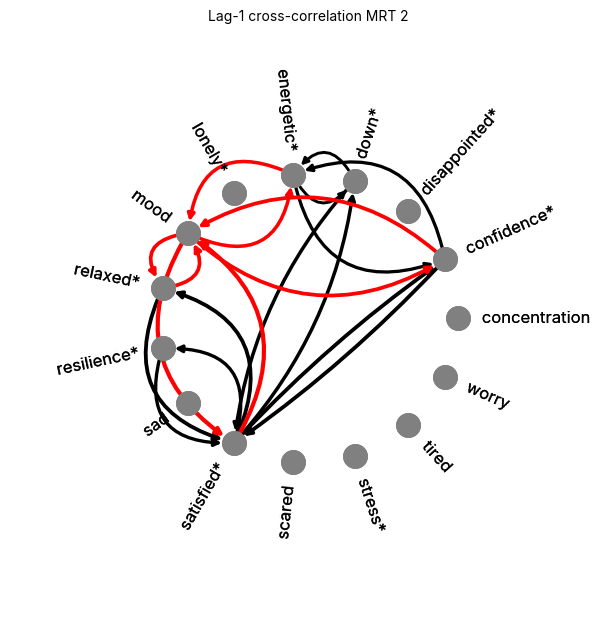

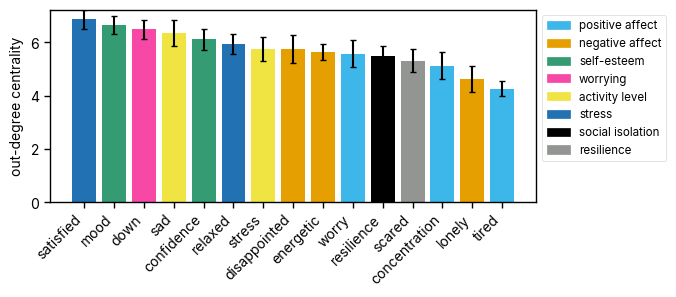

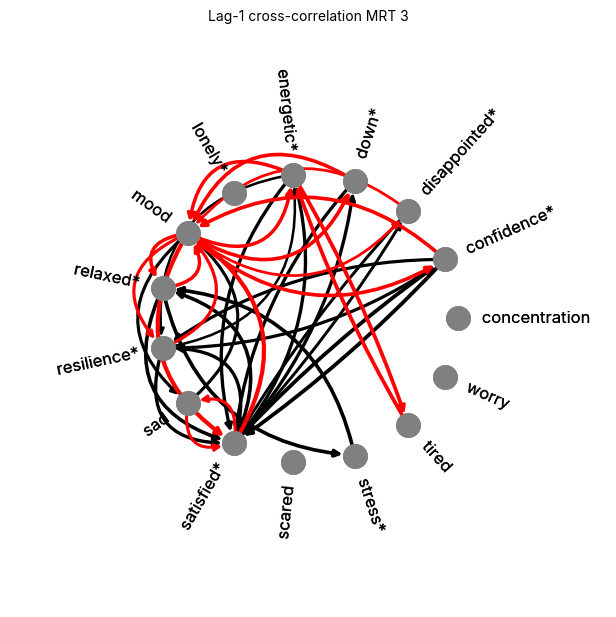

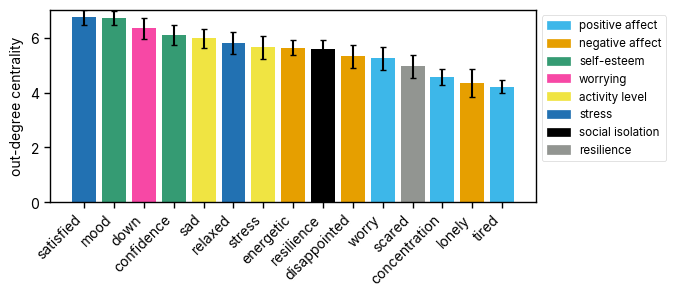

In [20]:
import pandas as pd
import data_utils
from plotting_styles import PaperStyle
import eval_reallabor_utils

lag = 1
MRT = [2, 3]
with PaperStyle(settings={'axes.grid': False, 'axes.facecolor':'white'}):
    for mrt in MRT:

        networks = []
        for i, df in enumerate(data_utils.read_data_files(data_utils.dataset_path(mrt, 'processed_csv_no_con'))):
            crosscorr = pd.concat([df[LABELS].iloc[:-lag], df[LABELS].iloc[lag:]], axis=1, keys=['before', 'after']).corr()
            crosscorr = crosscorr.loc['before', 'after'].fillna(0)
            networks.append(tc.tensor(crosscorr.to_numpy()))
        networks = tc.stack(networks, dim=0)
        networks = networks[:, alph_order, :][:, :, alph_order]
        alph_labels = np.array(PRINT_LABELS)[alph_order].tolist()
        # out_degree_centrality = eval_reallabor_utils.weighted_degree_centrality(networks, mode='out')
        ax, sig_adj = plot_network_graph(networks, node_labels=alph_labels, invert_negative=True, hide_self_connections=True,
                                          title=f'Lag-{lag} cross-correlation MRT {mrt}', alpha_level=1e-22, fisher_transform=True)
        if SAVE:
            # plt.savefig(f'../results/_paper/cross_correlation_mrt{mrt}.pdf')
            plt.savefig(f'../results/_paper/cross_correlation_mrt{mrt}.svg')
        plot_out_degree_centrality(networks, node_labels=alph_labels, significant_only=True)
        plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))
        if SAVE:
            # plt.savefig(f'../results/_paper/out_centrality_cross_correlation_mrt{mrt}.png')
            plt.savefig(f'../results/_paper/out_centrality_cross_correlation_mrt{mrt}.svg')
    plt.show()

## PLRNN networks

In [43]:
MRT = [2, 3]
models = {}
for mrt in MRT:
    print(f'Loading models for MRT {mrt}')
    results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_every_day')
    models[mrt] = eval_reallabor_utils.ModelCatalogue(results_dir, only_valid_days=True)

Loading models for MRT 2
Loading models for MRT 3


Initial conditions

In [34]:
initial_condition_version = 'trajectory'        # 'trajectory', 'unit vectors'

### 1) Traditional version

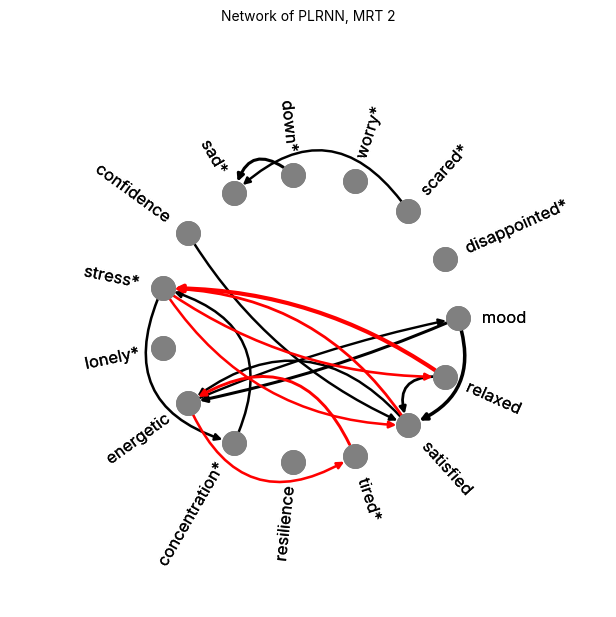

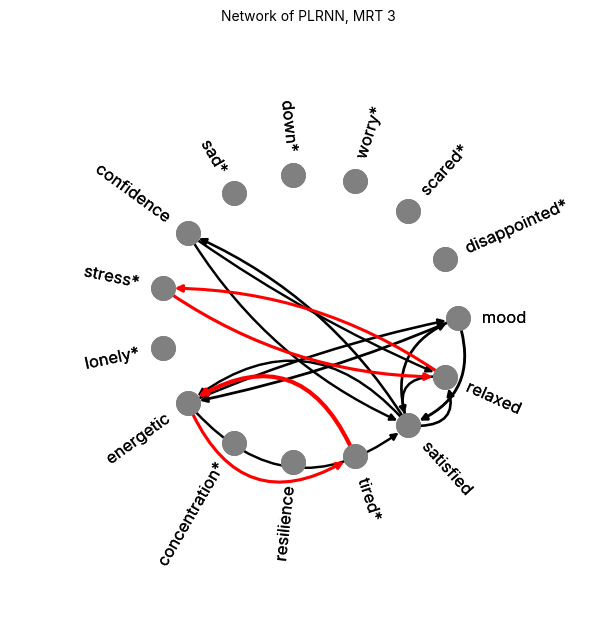

In [17]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
combined_eval_file = []
all_networks = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dirs = models[mrt].get_latest_model_dirs(p, timestep=1000)
            # model_dirs = [models.get_best_latest_model_dir(p, timestep=1000)]
            participant_networks = []
            for model_dir in model_dirs:            
                if model_dir is None:
                    continue
                args = utils.load_args(model_dir)
                model = PLRNN()
                model.init_from_model_path(model_dir)
                if initial_condition_version == 'trajectory':
                    x = tc.tensor(df[LABELS].to_numpy()).float()
                elif initial_condition_version == 'unit vectors':
                    x = tc.cat((tc.eye(len(LABELS)).float(), tc.zeros(len(LABELS)).float().unsqueeze(0)), 0)
                network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
                participant_networks.append(network)
            if len(participant_networks) > 0:
                participant_networks = tc.stack(participant_networks, dim=0).mean(0)
                networks.append(participant_networks)
        
        if len(networks) > 0:
            networks = tc.stack(networks, dim=0)
            plot_network_graph(networks, node_labels=PRINT_LABELS, title=f'Network of PLRNN, MRT {mrt}', alpha_level=0.05/(15**2), fisher_transform=False, invert_negative=True, edge_threshold=0.03)
            if SAVE:
                # plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn_pseudoinverse.png', dpi=300)
                plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn_pseudoinverse.svg')
            # plot_out_degree_centrality(networks, node_labels=PRINT_LABELS)
            # plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))
            # if SAVE:
            #     plt.savefig(f'../results/_paper/out_centrality_mrt_{mrt}_plrnn.png', dpi=300)
            # all_networks.append(networks)
    plt.show()

### 2) Using empirical covariance

No counterintuitive connections found.
No counterintuitive connections found.
Found no Covariance Gamma for 0 models.


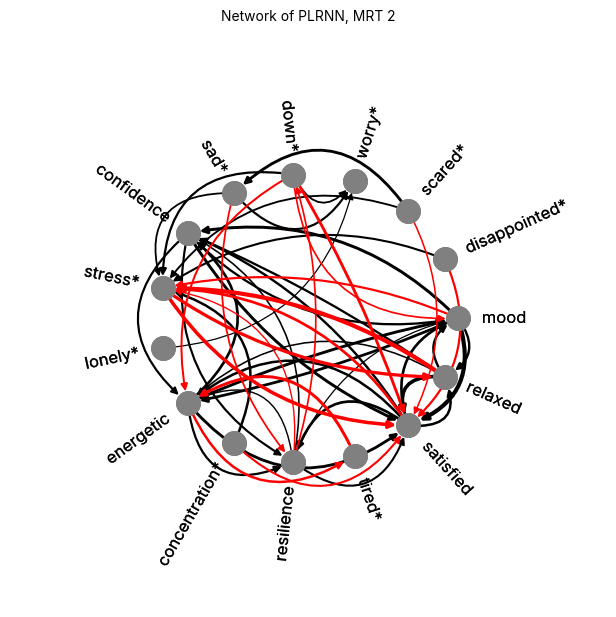

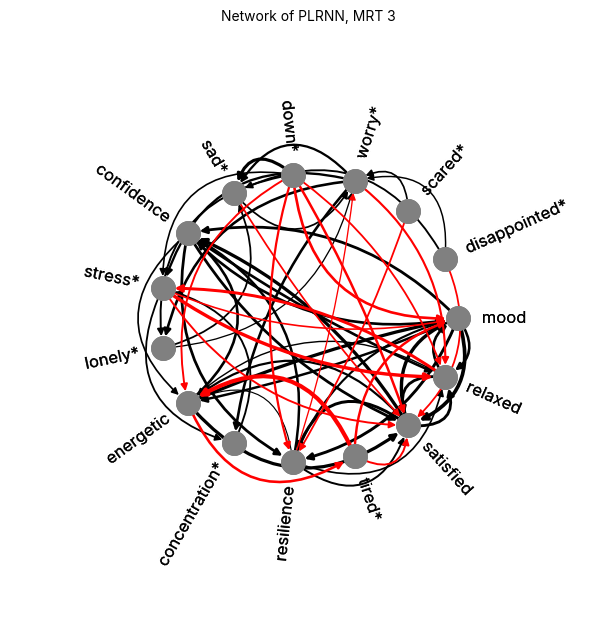

In [44]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
combined_eval_file = []
all_networks = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dirs = models[mrt].get_latest_model_dirs(p, timestep=1000)
            # model_dirs = [models.get_best_latest_model_dir(p, timestep=1000)]
            participant_networks = []
            no_gamma_found = 0
            for model_dir in model_dirs:            
                if model_dir is None:
                    continue
                args = utils.load_args(model_dir)
                model = PLRNN()
                model.init_from_model_path(model_dir)
                try:
                    Gamma = tc.load(data_utils.join_ordinal_bptt_path(model_dir, 'empirical_covariance.pt'))
                except FileNotFoundError:
                    no_gamma_found += 1
                    continue
                if initial_condition_version == 'trajectory':
                    x = tc.tensor(df[LABELS].to_numpy()).float()
                elif initial_condition_version == 'unit vectors':
                    x = tc.cat((tc.eye(len(LABELS)).float(), tc.zeros(len(LABELS)).float().unsqueeze(0)), 0)
                network = eval_reallabor_utils.get_network_matrix(model, x, Gamma=Gamma).nanmean(0)
                participant_networks.append(network)
            if len(participant_networks) > 0:
                participant_networks = tc.stack(participant_networks, dim=0).mean(0)
                networks.append(participant_networks)
        
        if len(networks) > 0:
            networks = tc.stack(networks, dim=0)
            plot_network_graph(networks, node_labels=PRINT_LABELS, title=f'Network of PLRNN, MRT {mrt}', alpha_level=0.01/(15**2), fisher_transform=False, invert_negative=True, max_edge_number=None)
            if SAVE:
                # plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn.png', dpi=300)
                plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn_empirical_cov.svg')
            # plot_out_degree_centrality(networks, node_labels=PRINT_LABELS)
            # plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))
            # if SAVE:
            #     plt.savefig(f'../results/_paper/out_centrality_mrt_{mrt}_plrnn.png', dpi=300)
            # all_networks.append(networks)
    print(f'Found no Covariance Gamma for {no_gamma_found} models.')
    plt.show()

### 3) Using Gaussian observation model (regularized with B penalty)

Found no Gaussian observation model for 0 models.


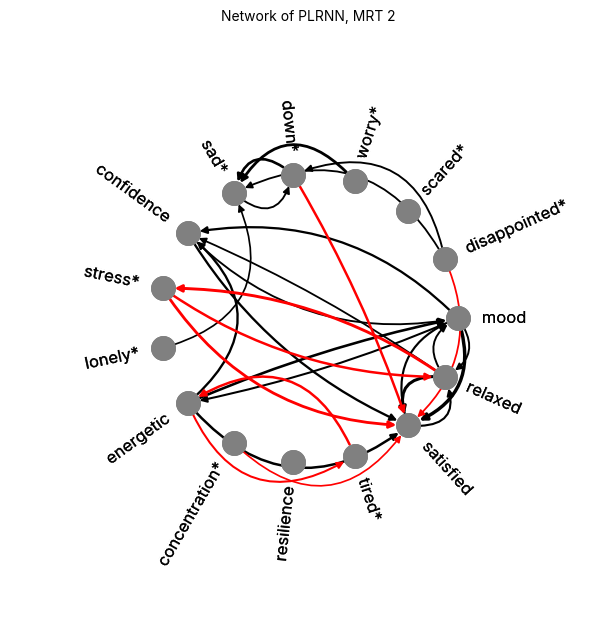

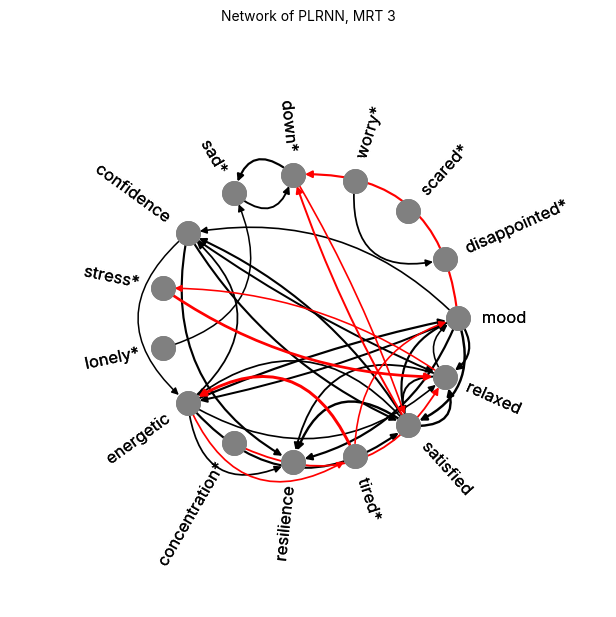

In [ ]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
combined_eval_file = []
all_networks = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dirs = models[mrt].get_latest_model_dirs(p, timestep=1000)
            # model_dirs = [models.get_best_latest_model_dir(p, timestep=1000)]
            participant_networks = []
            no_obs_model_found = 0
            for model_dir in model_dirs:            
                if model_dir is None:
                    continue
                args = utils.load_args(model_dir)
                model = PLRNN()
                model.init_from_model_path(model_dir)
                try:
                    obs_model = tc.load(data_utils.join_ordinal_bptt_path(model_dir, 'gaussian_obs_model_B_penalty.pt'))
                    B = obs_model['B']
                    Gamma = obs_model['Gamma']
                except FileNotFoundError:
                    no_obs_model_found += 1
                    continue
                if initial_condition_version == 'trajectory':
                    x = tc.tensor(df[LABELS].to_numpy()).float()
                elif initial_condition_version == 'unit vectors':
                    x = tc.cat((tc.eye(len(LABELS)).float(), tc.zeros(len(LABELS)).float().unsqueeze(0)), 0)
                network = eval_reallabor_utils.get_network_matrix(model, x, B=B, Gamma=Gamma).nanmean(0)
                participant_networks.append(network)
            if len(participant_networks) > 0:
                participant_networks = tc.stack(participant_networks, dim=0).mean(0)
                networks.append(participant_networks)
        
        if len(networks) > 0:
            networks = tc.stack(networks, dim=0)
            plot_network_graph(networks, node_labels=PRINT_LABELS, title=f'Network of PLRNN, MRT {mrt}', alpha_level=0.05/(15**2), fisher_transform=False, invert_negative=True, max_edge_number=30)
            if SAVE:
                # plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn.png', dpi=300)
                plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn_gaussian_obs_model_b_penalty.svg')
            # plot_out_degree_centrality(networks, node_labels=PRINT_LABELS)
            # plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))
            # if SAVE:
            #     plt.savefig(f'../results/_paper/out_centrality_mrt_{mrt}_plrnn.png', dpi=300)
            # all_networks.append(networks)
    print(f'Found no Gaussian observation model for {no_obs_model_found} models.')
    plt.show()

### 4) Using Gaussian observation model (unregularized)

In [ ]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
combined_eval_file = []
all_networks = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dirs = models[mrt].get_latest_model_dirs(p, timestep=1000)
            # model_dirs = [models.get_best_latest_model_dir(p, timestep=1000)]
            participant_networks = []
            no_obs_model_found = 0
            for model_dir in model_dirs:            
                if model_dir is None:
                    continue
                args = utils.load_args(model_dir)
                model = PLRNN()
                model.init_from_model_path(model_dir)
                try:
                    obs_model = tc.load(data_utils.join_ordinal_bptt_path(model_dir, 'gaussian_obs_model.pt'))
                    B = obs_model['B']
                    Gamma = obs_model['Gamma']
                except FileNotFoundError:
                    no_obs_model_found += 1
                    continue
                if initial_condition_version == 'trajectory':
                    x = tc.tensor(df[LABELS].to_numpy()).float()
                elif initial_condition_version == 'unit vectors':
                    x = tc.cat((tc.eye(len(LABELS)).float(), tc.zeros(len(LABELS)).float().unsqueeze(0)), 0)
                network = eval_reallabor_utils.get_network_matrix(model, x, B=B, Gamma=Gamma).nanmean(0)
                participant_networks.append(network)
            if len(participant_networks) > 0:
                participant_networks = tc.stack(participant_networks, dim=0).mean(0)
                networks.append(participant_networks)
        
        if len(networks) > 0:
            networks = tc.stack(networks, dim=0)
            plot_network_graph(networks, node_labels=PRINT_LABELS, title=f'Network of PLRNN, MRT {mrt}', alpha_level=0.05/(15**2), fisher_transform=False, invert_negative=True, max_edge_number=30)
            if SAVE:
                # plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn.png', dpi=300)
                plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn_gaussian_obs_model.svg')
            # plot_out_degree_centrality(networks, node_labels=PRINT_LABELS)
            # plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))
            # if SAVE:
            #     plt.savefig(f'../results/_paper/out_centrality_mrt_{mrt}_plrnn.png', dpi=300)
            # all_networks.append(networks)
    print(f'Found no Gaussian observation model for {no_obs_model_found} models.')
    plt.show()

TypeError: 'ModelCatalogue' object is not subscriptable

## KalmanFilter networks

In [36]:
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
models = {}

for mrt in MRT:
    results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_Kalman_every_day')
    models[mrt] = eval_reallabor_utils.ModelCatalogue(results_dir, only_valid_days=True)

In [41]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from comparison_models.simple_models.models import KalmanFilter
MRT = [2, 3]
combined_eval_file = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:

        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            participant_networks = []
            model_dirs = models[mrt].get_latest_model_dirs(p, timestep=1000)
            # model_dirs = [models[mrt].get_best_latest_model_dir(p, timestep=1000)]
            for model_dir in model_dirs:
                if model_dir is None:
                    continue
                args = utils.load_args(model_dir)
                model = KalmanFilter(args)
                model.init_from_model_path(model_dir)
                network = eval_reallabor_utils.get_network_matrix(model)
                participant_networks.append(network)
            if len(participant_networks) > 0:
                participant_networks = tc.stack(participant_networks, dim=0).mean(0)
                networks.append(participant_networks)
        
        if len(networks) > 0:
            if networks[0].ndim==2:
                networks = tc.stack(networks, dim=0)
            else:
                networks = tc.concat(networks, dim=0)
            plot_network_graph(networks, node_labels=PRINT_LABELS, title=f'Network of KalmanFilter, MRT {mrt}', alpha_level=0.05/(15**2), hide_self_connections=True, invert_negative=True, max_edge_number=30)
            if SAVE:
                plt.savefig(f'../results/_paper/networks_mrt_{mrt}_Kalman.svg', dpi=600)
            # plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))

    plt.show()

KeyError: 'Sigma'

Networks of VAR models

In [39]:
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
models = {}

for mrt in MRT:
    results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_SimpleModels_every_day')
    models[mrt] = eval_reallabor_utils.ModelCatalogue(results_dir, latent_model='VAR1', only_valid_days=True)

No counterintuitive connections found.
No counterintuitive connections found.


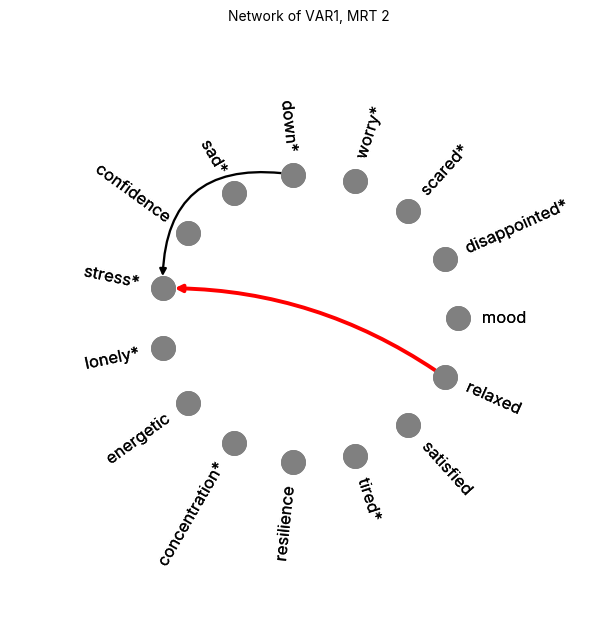

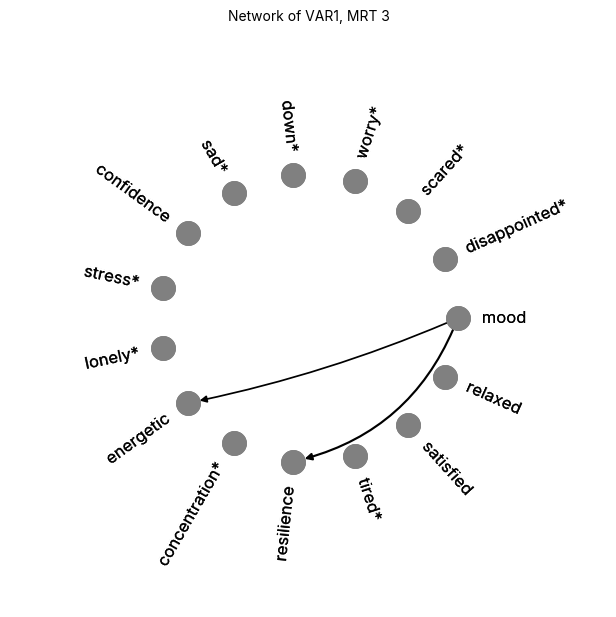

In [40]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from comparison_models.simple_models.models import VAR1

MRT = [2,3]
combined_eval_file = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_SimpleModels_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models[mrt].get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = VAR1(args)
            model.init_from_model_path(model_dir)
            network = eval_reallabor_utils.get_network_matrix(model)
            networks.append(network)
        
        if len(networks) > 0:
            networks = tc.stack(networks, dim=0)
            plot_network_graph(networks, node_labels=PRINT_LABELS, title=f'Network of VAR1, MRT {mrt}', alpha_level=0.05/(15**2), fisher_transform=False, invert_negative=True, max_edge_number=30)
            if SAVE:
                plt.savefig(f'../results/_paper/networks_mrt_{mrt}_VAR1.svg', dpi=600)
            # plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))

    plt.show()